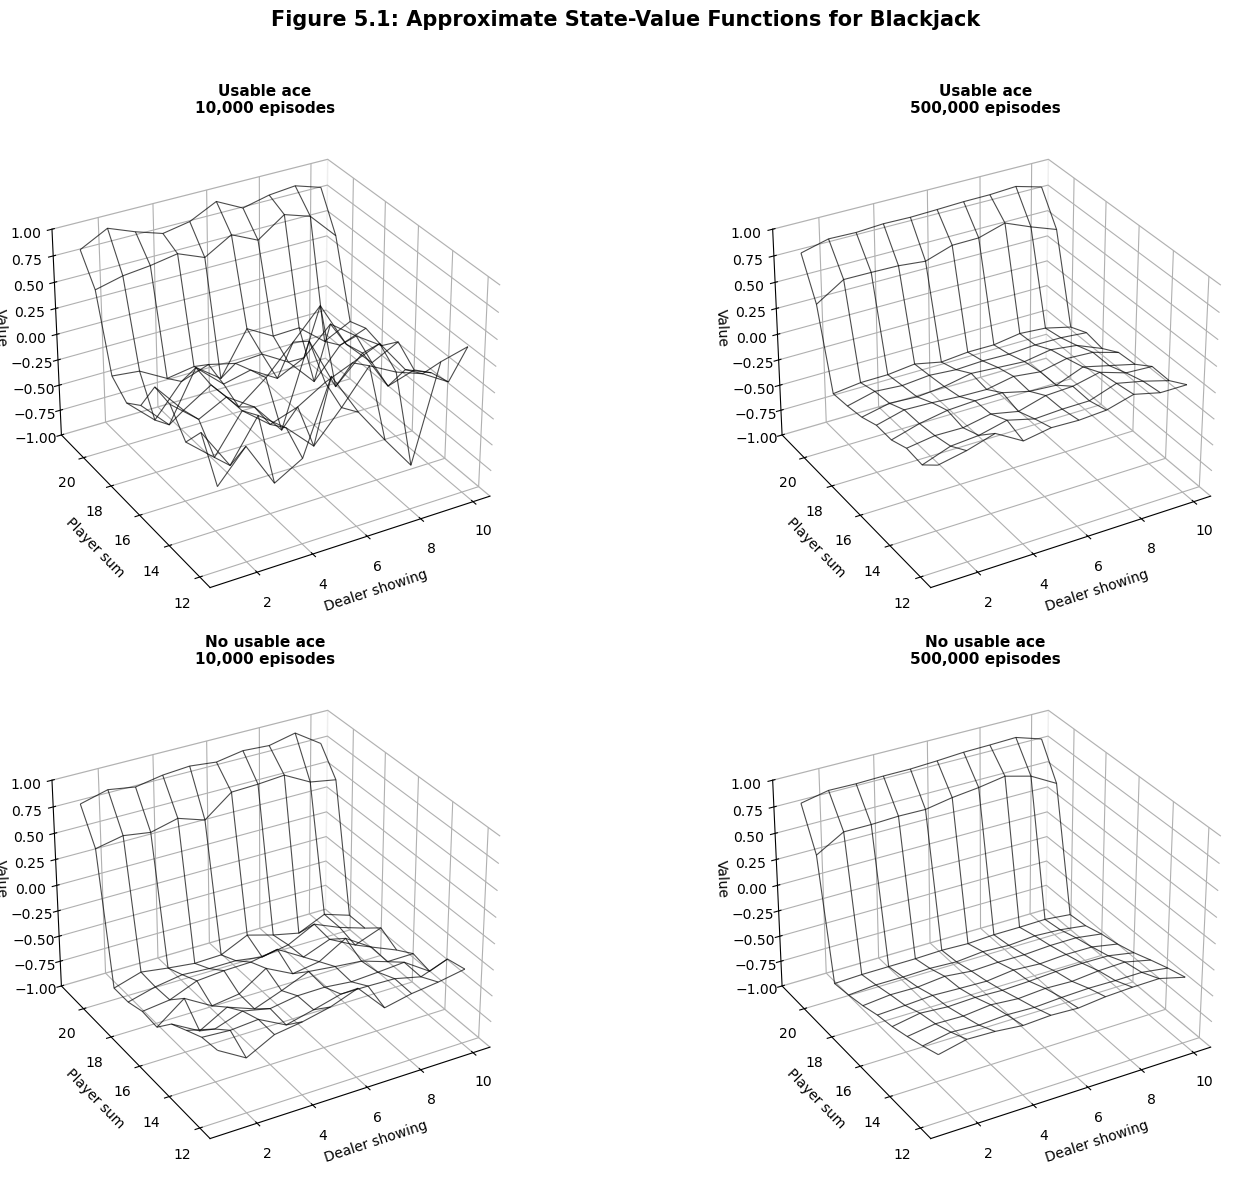

In [ ]:
#Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Fgure 5.1
# Monte Carlo On policy
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

class BlackjackEnvironment:
    """
    Blackjack Environment Implementation
    
    - the goal of blackjack is to obtain cards whose sum is as great as 
      possible without exceeding 21
    - all face cards count as 10, and an ace can count either as 1 or as 11
    - each player competes independently against the dealer
    - te game begins with two cards dealt to both dealer and player
    - one of the dealer's cards is face up (showing card) and one is face down
    
    State Space (200 states total):
    - player's current sum (12-21): 10 possible values
    - dealer's showing card (Ace-10): 10 possible values  
    - whether player holds a usable ace (t/f boolean): 2 possible values
    - total: 10 × 10 × 2 = 200 states
    
    note: player sums below 12 are not included because the player should 
    always hit with sum < 12 (no decision to be made)
    
    reward structure:
    - +1 for winning
    - -1 for losing
    - 0 for draw
    - no intermediate rewards
    -discount factor/gamma γ = 1 (no discounting) as stated in textbook
    
    environment assumptions (from textbook):
    - cards are dealt from an infinite deck (with replacement)
    - so no advantage to keeping track of cards already dealt
    """
    # defining constants
    # action constants for better readability
    ACTION_STICK = 0
    ACTION_HIT = 1
    
    # dealer threshold - dealer must stick at this sum or higher
    DEALER_STICK_THRESHOLD = 17
    
    # blackjack winning total
    BLACKJACK_TARGET = 21
    
    # reward constants
    REWARD_WIN = 1
    REWARD_LOSS = -1
    REWARD_DRAW = 0
    
    def __init__(self):
        """
        initialize the blackjack environment
        
        for infinite deck assumption, we set up uniform probabilities
        for cards 1-10, where:
        - Card 1 represents Ace
        - Cards 2-9 represent their face value
        - Card 10 represents 10, J, Q, K (all valued at 10)
        """
        # beginning game state
        self.player_hand = []
        self.dealer_hand = []
        
        # random number generator for card draws
        self.rng = np.random.default_rng()
    
    def draw_card(self):
        """
        draw a card from infinite deck
        
        note from textbook: 
        - draws are independent of each other (simplifcattion)
        
        implementation details from textbook:
        - discrete uniform distribution over [1, 10]
        - card value 10 represents any 10-value card (10, J, Q, K)
        """
        # draw uniformly from 1 to 10 (inclusive)
        card_value = self.rng.integers(low=1, high=11)
        return card_value
    
    def usable_ace(self, hand):
        """
        determine if the hand has a usable ace
        
    	from textbook section 5.1:
        "if the player holds an ace that he could count as 11 without going bust,
        then the ace is said to be usable. in this case it is always counted as 11
        because counting it as 1 would make the sum 11 or less, in which case there
        is no decision to be made because, obviously, the player should always hit."
        basically always hit on 12 or less
        (sum of all cards) + 10 <= 21
        """
        # Check if hand contains at least one ace (value 1)
        has_ace = 1 in hand
        
        if not has_ace:
            return False
        
        # calculate sum with all aces counted as 1
        current_sum = sum(hand)
        
        # check if we can count one ace as 11 (adding 10 to current sum)
        # without exceeding 21
        can_use_ace_as_eleven = (current_sum + 10) <= self.BLACKJACK_TARGET
        
        return can_use_ace_as_eleven
    
    def sum_hand(self, hand):
        """
        Calculate the sum of a hand, accounting for usable ace
        - Start by counting all aces as 1
        - if there's a usable ace, add 10 to count it as 11
        """
        # sum all cards (aces counted as 1)
        total_sum = sum(hand)
        
        # if we have a usable ace, count it as 11 instead of 1
        # this adds 10 to the total
        if self.usable_ace(hand):
            total_sum += 10
        
        return total_sum
    
    def is_bust(self, hand):
        """
        check if hand is bust (sum > 21)
        """
        return self.sum_hand(hand) > self.BLACKJACK_TARGET
    
    def reset(self):
        """
        starts a new round
        - deal initial cards to both player and dealer
        - if player gets natural (21), handle it according to rules
        - return the initial observable state
        """
        # deal two cards to player and dealr
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        
        # dealer's showing card is the first card
        dealer_showing_card = self.dealer_hand[0]
        
        # calculate player's sum and check for usable ace
        player_total = self.sum_hand(self.player_hand)
        has_usable_ace = self.usable_ace(self.player_hand)
        
        initial_state = (player_total, dealer_showing_card, has_usable_ace)
        
        return initial_state  # state tuple: (player sum, dealer showing, usable ace)
    
    def step(self, action):
        """
        execute one turn of the game based on player's action
        - if player hits: draw card, check for bust, return new state
        - if player sticks: dealer plays, determine winner, return reward
        """
        # CASE 1: player HIT
        if action == self.ACTION_HIT:
            # draw a new card and add to player's hand
            new_card = self.draw_card()
            self.player_hand.append(new_card)
            
            # check if player went bust
            if self.is_bust(self.player_hand):
                # player loses immediately
                # turn ends, no next state needed
                return None, self.REWARD_LOSS, True
            
            # player didn't bust - game continues
            # calculate new state
            player_total = self.sum_hand(self.player_hand)
            dealer_showing_card = self.dealer_hand[0]
            has_usable_ace = self.usable_ace(self.player_hand)
            
            next_state = (player_total, dealer_showing_card, has_usable_ace)
            
            # no reward yet, gmae not done
            return next_state, 0, False
        
        # CASE 2: Player STICK
        elif action == self.ACTION_STICK:
            # player's turn is over - now dealer plays
            dealer_final_sum, dealer_busted = self.dealer_policy()
            
            # calculate player's final sum
            player_final_sum = self.sum_hand(self.player_hand)
            
            # determine outcome and assign reward
            if dealer_busted:
                reward = self.REWARD_WIN #player wins
            elif player_final_sum > dealer_final_sum: # Player has higher sum - player wins
                reward = self.REWARD_WIN
            elif player_final_sum < dealer_final_sum: # Dealer has higher sum - player loses
                reward = self.REWARD_LOSS
            else: # Same sum - its a draw
                reward = self.REWARD_DRAW
            
            # episode complete
            return None, reward, True
        
        else: #this should not happen but for safety/testign
            raise ValueError(f"Invalid action: {action}. Must be 0 (stick) or 1 (hit)")
    
    def dealer_policy(self):
        """
        dealer's fixed strategy
        
        from textbook Section 5.1:
        "The dealer hits or sticks according to a fixed strategy without choice:
        he sticks on any sum of 17 or greater, and hits otherwise."
        basically:
        - Dealer keeps hitting until reaching threshold or busting
        - No choice involved - purely deterministic based on current sum
        """
        # dealer plays out their hand
        while True:
            current_dealer_sum = self.sum_hand(self.dealer_hand)
            
            # Check if dealer should stick
            if current_dealer_sum >= self.DEALER_STICK_THRESHOLD:
                # dealer sticks - return final sum and bust status
                dealer_busted = current_dealer_sum > self.BLACKJACK_TARGET
                return current_dealer_sum, dealer_busted
            
            # dealer must hit (sum < 17)
            new_card = self.draw_card()
            self.dealer_hand.append(new_card)
            
            # check if dealer busted
            if self.is_bust(self.dealer_hand):
                # dealer went bust
                final_sum = self.sum_hand(self.dealer_hand)
                return final_sum, True
    
    def natural(self, hand):
        """
        check if hand is a natural (Ace + 10-card = 21 with 2 cards)
        
        from textbook:
        if the player has 21 immediately (an ace and a 10-card), it is called 
        a natural. he then wins unless the dealer also has a natural, in which 
        case the game is a draw."
        """
        # check for exactly 2 cards
        if len(hand) != 2:
            return False
        
        # check if sum equals 21
        # (must use sum_hand to properly handle ace)
        if self.sum_hand(hand) != self.BLACKJACK_TARGET:
            return False
        
        # check for ace and 10-card combination
        has_ace = 1 in hand
        has_ten = 10 in hand
        
        return has_ace and has_ten


def simple_policy(state):
    """
    policy to evaluate (from fig 5.1 caption)
    
    from textbook Section 5.1:
    "Consider the policy that sticks if the player's sum is 20 or 21, 
    and otherwise hits."
    
    fixed, deterministic policy:
    - Stick (action 0) if player sum is 20 or 21
    - Hit (action 1) otherwise
    """
    # unpacking the state tuple
    player_sum, dealer_showing, usable_ace = state
    
    # policy decision based on player's sum
    if player_sum >= 20:
        # stick on 20 or 21
        return BlackjackEnvironment.ACTION_STICK
    else:
        # hit on anything less than 20
        return BlackjackEnvironment.ACTION_HIT


def first_visit_mc_prediction(policy, env, num_episodes, gamma=1.0):
    """
    first-visit Monte Carlo policy evaluation
    
    Psuedocode of Algorithm from Sutton & Barto Section 5.1 (page 92):
    
    Input: a policy π to be evaluated
    Initialize:
        V(s) ∈ RealNum, arbitrarily, for all s ∈ S
        Returns(s) ← an empty list, for all s ∈ S
    Loop forever (for each episode):
        Generate an episode following pi: S_0, A_0, R_1, S_1, A_1, R-1, ..., S_{T-1}, A_{T-1}, R_T
        G ← 0
        Loop for each step of episode, t = T-1, T-2, ..., 0:
            G ← (gamma)G + R_{t+1}
            Unless S_t appears in S_0, S_1, ..., S_{t-1}:
                Append G to Returns(S_t)
                V(S_t) ← average(Returns(S_t))
    
    notes from textbook:
    -  first-visit MC method estimates v_π(s) as the average of the returns 
       following first visits to s
    -  each return is an independent, identically distributed estimate of v_π(s)
    -  the std dev of error falls as 1/√n where n is the number of 
       returns averaged
    """
    
    # initialize value function arbitrarily (we use 0.0 for all states)
    V = defaultdict(float)
    
    # returns(s) stores list of returns following first visits to state s
    # from textbook: We need to track all returns to compute the average
    # each state maps to a list of all returns observed after first visits
    Returns = defaultdict(list)
        
    # loop for each episode
    for episode_num in range(num_episodes):
        # geneate episode following polciy store tuples of (state, action, reward) for each time step
        episode_history = []
        
        # reset environment to get initial state S_)
        current_state = env.reset()
    
        episode_complete = False
        
        while not episode_complete:   # generate complete episode until terminal state
            action = policy(current_state) #get action from policy
            
            # take action in environment
            next_state, reward, episode_complete = env.step(action)
            
            # store this transition (state, action, reward)
            episode_history.append((current_state, action, reward))
            
            # move to next state (if episode continues)
            if not episode_complete:
                current_state = next_state
        
        # CALCULATE RETURNS AND UPDATE VALUE FUNCTION
        # work backwards from end of episode to beginning
        cumulative_return = 0.0
        
        # track which states we've already seen in this backward pass
        # we only want to update a state the FIRST time we see it (going backwards)
        states_seen_in_reverse = set()
        
        # loop backwards through episode (t = T-1, T-2, ..., 0)
        for step_index in range(len(episode_history) - 1, -1, -1):
            
            # episode_history[step_index] = (S_t, A_t, R_{t+1})
            state_at_step, action_at_step, reward_received = episode_history[step_index]
            
            # calculate return: G ← γ * G + R_{t+1}
            cumulative_return = gamma * cumulative_return + reward_received
            
            # make sure we are not summing returns for states we've already seen in this episode
            if state_at_step not in states_seen_in_reverse:
                
                # mark state as seen
                states_seen_in_reverse.add(state_at_step)
                
                # append return to Returns(S_t)
                Returns[state_at_step].append(cumulative_return)
                
                # update value estimate: V(S_t) ← average(Returns(S_t))
                V[state_at_step] = np.mean(Returns[state_at_step])
    
    return V


def first_visit_mc_prediction_with_counts(policy, env, num_episodes, gamma=1.0):
    """
    First-visit Monte Carlo prediction with visit counts tracked
    
    alternative implementation that tracks visit counts separately. which is can be more memory efficient for large numbers of episodes since we
    don't store every single return
    
    mathmatically equivalent to the version above, but uses incremental updates:
    V(S) ← V(S) + (1/N(S)) * [G - V(S)]
    
    where N(S) is the number of times we've visited state S.
    """
    
    V = defaultdict(float)
    
    # tracks how many times we've updated each state's value
    visit_counts = defaultdict(int)
    
    
    for episode_num in range(num_episodes):
        
        # GENERATE EPISODE
        episode_history = []
        current_state = env.reset()
        episode_complete = False
        
        while not episode_complete:
            action = policy(current_state)
            next_state, reward, episode_complete = env.step(action)
            episode_history.append((current_state, action, reward))
            
            if not episode_complete:
                current_state = next_state
        
        # process backwards to calculate returns and update V
        cumulative_return = 0.0
        states_seen_in_reverse = set()
        
        for step_index in range(len(episode_history) - 1, -1, -1):
            state_at_step, action_at_step, reward_received = episode_history[step_index]
            
            # add return
            cumulative_return = gamma * cumulative_return + reward_received
            
            # first visit check
            if state_at_step not in states_seen_in_reverse:
                states_seen_in_reverse.add(state_at_step)
                
                # increment visit count
                visit_counts[state_at_step] += 1
                
                # incremental update formula
                # this is mathematically equivalent to taking the mean of all returns
                n = visit_counts[state_at_step]
                current_value = V[state_at_step]
                V[state_at_step] = current_value + (1.0 / n) * (cumulative_return - current_value)
        
    
    return V, visit_counts


#everything below is for plotting
        
def state_value_to_arrays(V, usable_ace):
    """
    convert state-value dictionary to 2D arrays for plotting
    
    the state space for plotting is:
    - X-axis: Dealer showing card (1-10, representing Ace through 10)
    - Y-axis: Player sum (12-21)
    - Z-axis: Value V(s)
    - need 2 separate plots for usable ace vs. no usable ace
    """
    
    # define the ranges for our state space
    player_sum_range = range(12, 22)  # 12 through 21
    dealer_showing_range = range(1, 11)  # 1 through 10
    
    # initialize 10x10 array with zeros
    value_grid = np.zeros((len(player_sum_range), len(dealer_showing_range)))
    
    # populate the grid with values from V
    for row_idx, player_sum in enumerate(player_sum_range):
        for col_idx, dealer_showing in enumerate(dealer_showing_range):
            state = (player_sum, dealer_showing, usable_ace)
            value_grid[row_idx, col_idx] = V[state]
    
    return value_grid


def plot_value_function(V, num_episodes, title_suffix=""):
    """
    create 3D plots in black and white
    """
    
    # create figure with white background
    fig = plt.figure(figsize=(10, 12), facecolor='white')
    
	#axes
    player_sum_range = np.arange(12, 22)
    dealer_showing_range = np.arange(1, 11)
    
    # I did have to look at the documentation for making a meshgrid/3d plot.
    dealer_mesh, player_mesh = np.meshgrid(dealer_showing_range, player_sum_range)
    
    # plot 1: Usable Ace (top subplot)
    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    
    # convert value function to 2D array
    values_usable_ace = state_value_to_arrays(V, usable_ace=True)
    
    # create wireframe plot (again referenced documentation for this)
    ax1.plot_wireframe(
        dealer_mesh, 
        player_mesh, 
        values_usable_ace,
        color='black',        
        linewidth=0.8,        
        alpha=0.7             
    )
    
    # axis labels
    ax1.set_xlabel('Dealer showing', fontsize=11, labelpad=8)
    ax1.set_ylabel('Player sum', fontsize=11, labelpad=8)
    ax1.set_zlabel('Value', fontsize=11, labelpad=8)
    
    # axis limits
    ax1.set_xlim(1, 10)
    ax1.set_ylim(12, 21)
    ax1.set_zlim(-1, 1)
    
    # title
    ax1.set_title('Usable ace', fontsize=12, pad=10, fontweight='bold')
    
    # viewing angle
    ax1.view_init(elev=30, azim=240)
    
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # plot 2: No Usable Ace (bottom subplot)
    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    
    values_no_usable_ace = state_value_to_arrays(V, usable_ace=False)
    
    ax2.plot_wireframe(
        dealer_mesh, 
        player_mesh, 
        values_no_usable_ace,
        color='black',
        linewidth=0.8,
        alpha=0.7
    )
    
    ax2.set_xlabel('Dealer showing', fontsize=11, labelpad=8)
    ax2.set_ylabel('Player sum', fontsize=11, labelpad=8)
    ax2.set_zlabel('Value', fontsize=11, labelpad=8)
    
    ax2.set_xlim(1, 10)
    ax2.set_ylim(12, 21)
    ax2.set_zlim(-1, 1)
    
    ax2.set_title('No usable ace', fontsize=12, pad=10, fontweight='bold')
    
    ax2.view_init(elev=30, azim=240)
    
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    
    ax2.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    fig.suptitle(
        f'After {num_episodes:,} episodes{title_suffix}',
        fontsize=14,
        fontweight='bold',
        y=0.98
    )
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


def plot_value_function_side_by_side(V_10k, V_500k):
    """
    create side-by-side comparison
    - Col 1: after 10,000 episodes
    - Col 2: after 500,000 episodes
    - Row 1: usable ace
    - Row 2: mo usable ace

    """
    
    fig = plt.figure(figsize=(16, 12), facecolor='white')
    
    # ranges
    player_sum_range = np.arange(12, 22)
    dealer_showing_range = np.arange(1, 11)
    
    # Create meshgrid
    dealer_mesh, player_mesh = np.meshgrid(dealer_showing_range, player_sum_range)
    
    # viewing angle
    elevation_angle = 30
    azimuth_angle = 240
    
    wireframe_style = {
        'color': 'black',
        'linewidth': 0.8,
        'alpha': 0.7
    }
    
    # ROW 1, COL 1: Usable ace, 10k episodes
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    values_1 = state_value_to_arrays(V_10k, usable_ace=True)
    ax1.plot_wireframe(dealer_mesh, player_mesh, values_1, **wireframe_style)
    ax1.set_xlabel('Dealer showing', fontsize=10)
    ax1.set_ylabel('Player sum', fontsize=10)
    ax1.set_zlabel('Value', fontsize=10)
    ax1.set_title('Usable ace\n10,000 episodes', fontsize=11, fontweight='bold')
    ax1.set_zlim(-1, 1)
    ax1.view_init(elev=elevation_angle, azim=azimuth_angle)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # ROW 1, COL 2: Usable ace, 500k episodes
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    values_2 = state_value_to_arrays(V_500k, usable_ace=True)
    ax2.plot_wireframe(dealer_mesh, player_mesh, values_2, **wireframe_style)
    ax2.set_xlabel('Dealer showing', fontsize=10)
    ax2.set_ylabel('Player sum', fontsize=10)
    ax2.set_zlabel('Value', fontsize=10)
    ax2.set_title('Usable ace\n500,000 episodes', fontsize=11, fontweight='bold')
    ax2.set_zlim(-1, 1)
    ax2.view_init(elev=elevation_angle, azim=azimuth_angle)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # ROW 2, COL 1: No usable ace, 10k episodes
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    values_3 = state_value_to_arrays(V_10k, usable_ace=False)
    ax3.plot_wireframe(dealer_mesh, player_mesh, values_3, **wireframe_style)
    ax3.set_xlabel('Dealer showing', fontsize=10)
    ax3.set_ylabel('Player sum', fontsize=10)
    ax3.set_zlabel('Value', fontsize=10)
    ax3.set_title('No usable ace\n10,000 episodes', fontsize=11, fontweight='bold')
    ax3.set_zlim(-1, 1)
    ax3.view_init(elev=elevation_angle, azim=azimuth_angle)
    ax3.xaxis.pane.fill = False
    ax3.yaxis.pane.fill = False
    ax3.zaxis.pane.fill = False
    ax3.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # ROW 2, COL 2: No usable ace, 500k episodes
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    values_4 = state_value_to_arrays(V_500k, usable_ace=False)
    ax4.plot_wireframe(dealer_mesh, player_mesh, values_4, **wireframe_style)
    ax4.set_xlabel('Dealer showing', fontsize=10)
    ax4.set_ylabel('Player sum', fontsize=10)
    ax4.set_zlabel('Value', fontsize=10)
    ax4.set_title('No usable ace\n500,000 episodes', fontsize=11, fontweight='bold')
    ax4.set_zlim(-1, 1)
    ax4.view_init(elev=elevation_angle, azim=azimuth_angle)
    ax4.xaxis.pane.fill = False
    ax4.yaxis.pane.fill = False
    ax4.zaxis.pane.fill = False
    ax4.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # title
    fig.suptitle('Figure 5.1: Approximate State-Value Functions for Blackjack', 
                 fontsize=15, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
if __name__ == "__main__":
	# create Blackjack environment
	env = BlackjackEnvironment()
	
	# run for 10,000 episodes
	num_episodes_10k = 10_000
	V_10k = first_visit_mc_prediction(simple_policy, env, num_episodes_10k)
	
	# plot results after 10,000 episodes: COMMENT OUT WHEN SUBMITTING
	#plot_value_function_textbook_style(V_10k, num_episodes_10k)
	
	#run  for 500,000 episodes
	num_episodes_500k = 500_000
	V_500k = first_visit_mc_prediction(simple_policy, env, num_episodes_500k)
	
	# plot results after 500,000 episodes: COMMENT OUT WHEN SUBMITTING
	#plot_value_function_textbook_style(V_500k, num_episodes_500k)
	
	# side-by-side comparison plot
	plot_value_function_side_by_side(V_10k, V_500k)
